In [1]:
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Wprowadzenie stałych

In [2]:
m = 2
d = 0.4
I = 0.32
b = 0.15
g = 9.81

t_start = 0
t_end = 10

## 1. Zamiana równania 2 rzędu na układ 1 rzędu

In [3]:
def calc_x(_: float, x_arg: np.ndarray) -> np.ndarray:
    x_1, x_2, *_ = x_arg
    dx_1 = x_2
    dx_2 = -(b / I) * x_2 - (m * g * d / I) * np.sin(x_1)
    return np.array([dx_1, dx_2])

# 2. Rozwiązać układ (Runge-Kutta 2 i 4 rzędu)

In [4]:
def impl_rungekutta_2(func: Callable[[float, np.ndarray], np.ndarray], t_span: tuple[float, float], y0: np.ndarray,
                      h: float) -> np.ndarray:
    n = int(np.ceil((t_span[1] - t_span[0]) / h))
    x = np.linspace(t_span[0], t_span[1], n)

    y = [y0]
    for it in range(1, n):
        y_prev = y[it - 1]
        x_prev = x[it - 1]
        y.append(y_prev + (
                func(x_prev, y_prev) +
                func(x_prev + h, y_prev + h * func(x_prev, y_prev))
        ) * h / 2)
    return np.array(y)


def impl_rungekutta_4(func: Callable[[float, np.ndarray], np.ndarray], t_span: tuple[float, float], y0: np.ndarray,
                      h: float) -> np.ndarray:
    n = int(np.ceil((t_span[1] - t_span[0]) / h))
    x = np.linspace(t_span[0], t_span[1], n)

    y = [y0]
    for it in range(1, n):
        y_prev = y[it - 1]
        x_prev = x[it - 1]

        k1 = h * func(x_prev, y_prev)
        k2 = h * func(x_prev + h / 2, y_prev + k1 / 2)
        k3 = h * func(x_prev + h / 2, y_prev + k2 / 2)
        k4 = h * func(x_prev + h, y_prev + k3)

        y.append(y_prev + (k1 + 2 * k2 + 2 * k3 + k4) / 6)
    return np.array(y)

Własna implementacja RK-2


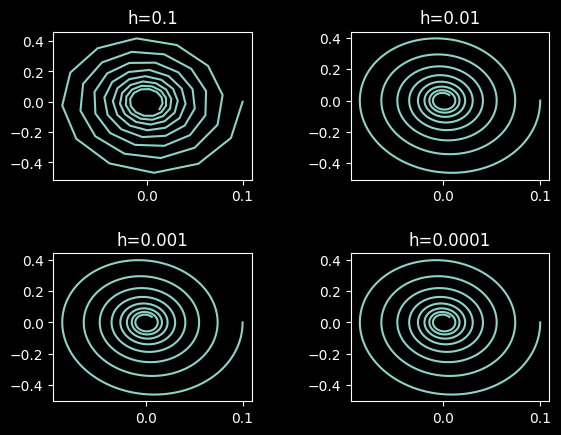

Własna implementacja RK-4


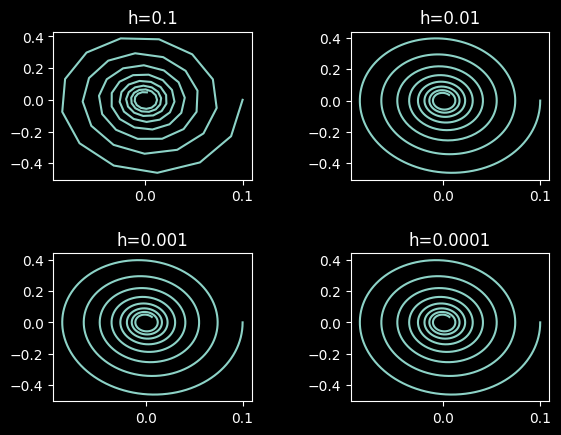

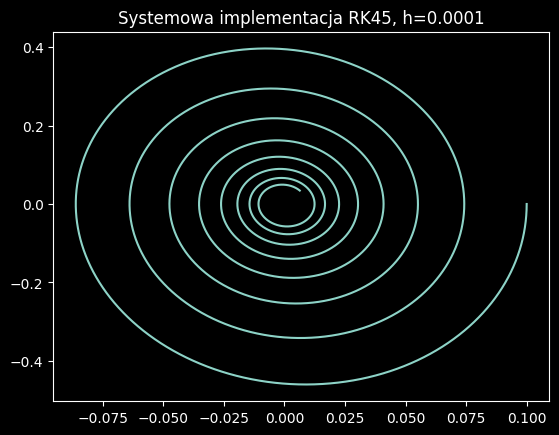

In [5]:
h_testing = [0.1, 0.01, 0.001, 0.0001]
testing_x0 = np.array([0.1, 0])

plt.figure()
plt.tight_layout()
print("Własna implementacja RK-2")
for i, test_h in enumerate(h_testing):
    plt.subplot(2, 2, i + 1)
    result_rk2 = impl_rungekutta_2(calc_x, t_span=(t_start, t_end), y0=testing_x0, h=test_h)
    plt.plot(result_rk2[:, 0], result_rk2[:, 1])
    plt.title(f"h={test_h}")
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

plt.figure()
plt.tight_layout()
print("Własna implementacja RK-4")
for i, test_h in enumerate(h_testing):
    plt.subplot(2, 2, i + 1)
    result_rk4 = impl_rungekutta_4(calc_x, t_span=(t_start, t_end), y0=testing_x0, h=test_h)
    plt.plot(result_rk4[:, 0], result_rk4[:, 1])
    plt.title(f"h={test_h}")
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

result_ref = np.transpose(solve_ivp(calc_x, t_span=(t_start, t_end), y0=testing_x0, method='RK45', max_step=1e-4).y)
plt.figure()
plt.plot(result_ref[:, 0], result_ref[:, 1])
plt.title('Systemowa implementacja RK45, h=0.0001')
plt.show()

theta_0 = 0.1 rad


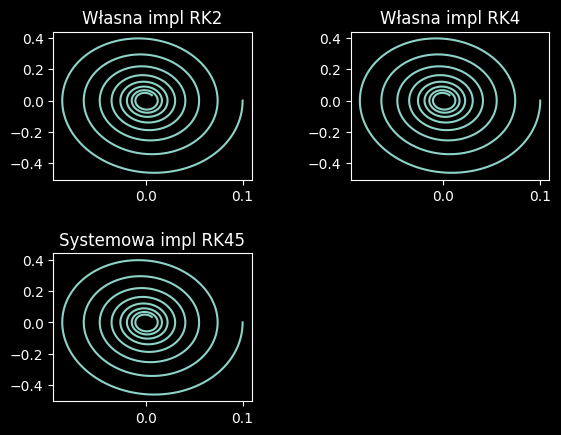

theta_0 = 0.5 rad


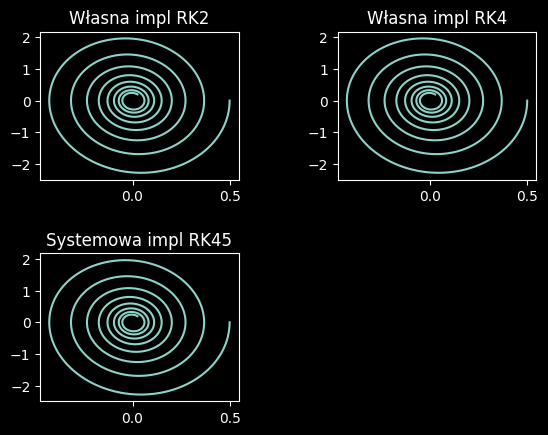

theta_0 = 1.2 rad


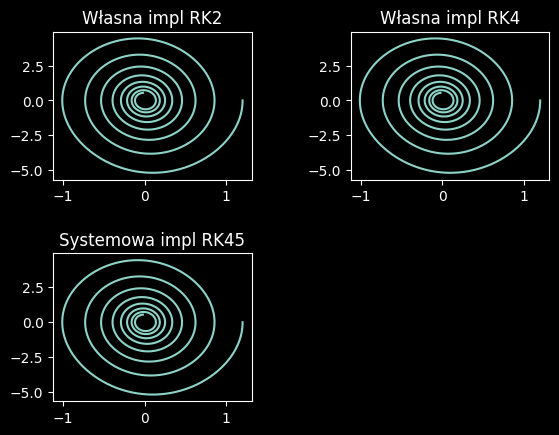

In [6]:
theta0_testing = [0.1, 0.5, 1.2]

for theta0 in theta0_testing:
    plt.figure()
    plt.tight_layout()
    print(f"theta_0 = {theta0} rad")
    x0 = np.array([theta0, 0])

    plt.subplot(2, 2, 1)
    res = impl_rungekutta_2(calc_x, t_span=(t_start, t_end), y0=x0, h=1e-4)
    plt.plot(res[:, 0], res[:, 1])
    plt.title("Własna impl RK2")

    plt.subplot(2, 2, 2)
    res = impl_rungekutta_4(calc_x, t_span=(t_start, t_end), y0=x0, h=1e-4)
    plt.plot(res[:, 0], res[:, 1])
    plt.title("Własna impl RK4")

    plt.subplot(2, 2, 3)
    res = np.transpose(solve_ivp(calc_x, t_span=(t_start, t_end), y0=x0, method='RK45', max_step=1e-4).y)
    plt.plot(res[:, 0], res[:, 1])
    plt.title("Systemowa impl RK45")

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()